## Imports von allen genutzten Librarys

In [1]:
import librosa
import numpy as np
import os
import copy

import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

Der Dateipfad zu den Daten wird gesetzt.

In [2]:
# setting up the data directory
DATA_DIR="cats_dogs/"

Hier wird eine Sound-Klasse erstellt. Der Filepath ist der zu der Wav-Datei, "Cat" ist ein Boolean welches true ist, wenn es sich um die Audio einer Katze handelt und False, wenn es ein Hund ist.

In [3]:
class Sound:
    def __init__(self, filePath, cat, spec = None):
        self.filePath = filePath
        self.cat = cat
        self.spec = spec

    def __str__(self):
        return f"Sound(filePath={self.filePath}, cat={self.cat}, spec={self.spec})"
    

## Data Unterstanding

Hier wird die Liste an Sound Objekten initialisiert und gezählt, wie viele Hunde und Katzen Audios es gibt. Das Spektrogramm bleibt hierbei erstmal leer und wird gesondert berechnet.

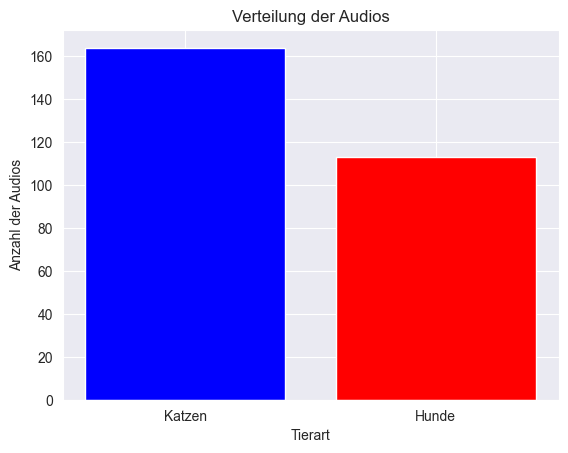

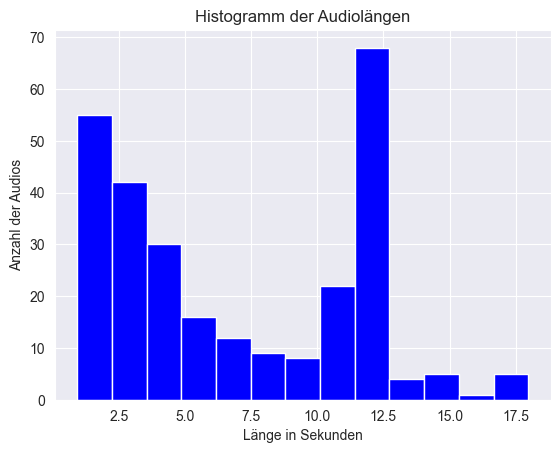

Targeted duration:  7.0
Number of Cat-Audios: 164
Number of Dog-Audios: 113


In [4]:
audiofiles = []
files = [f for f in os.listdir(DATA_DIR) if os.path.isfile(os.path.join(DATA_DIR, f))]
dog_counter = 0
cat_counter = 0

for file in files:
    isCat = file.split("_")[0] == "cat"
    if isCat:
        cat_counter += 1
    else:
        dog_counter += 1
    audiofiles.append(Sound(filePath=DATA_DIR+file ,cat=isCat))

labels = ['Katzen', 'Hunde']
counts = [cat_counter, dog_counter]

plt.bar(labels, counts, color = ['blue', 'red'])

plt.title ('Verteilung der Audios')
plt.xlabel ('Tierart')
plt.ylabel('Anzahl der Audios')

plt.show()


audio_lengths = []
for audiofile in audiofiles:
    y, sr = librosa.load(audiofile.filePath)
    audio_lengths.append(librosa.get_duration(y=y, sr=sr))

plt.hist(audio_lengths, bins=13, color='blue')
plt.title('Histogramm der Audiolängen')
plt.xlabel('Länge in Sekunden')
plt.ylabel('Anzahl der Audios')
plt.show()

TARGETDURATION = np.ceil(np.mean(audio_lengths))

print("Targeted duration: ", TARGETDURATION)
print ("Number of Cat-Audios:", cat_counter)
print ("Number of Dog-Audios:", dog_counter)


In [5]:
def getMelSpecLabel(audiofile:Sound):
    y, sr = librosa.load(audiofile.filePath)
    # Passing through arguments to the Mel filters
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128,
                                       fmax=8000)
    audiofile.spec = librosa.power_to_db(S, ref=np.max)

def plotMel(audiofile:Sound):
    fig, ax = plt.subplots()
    img = librosa.display.specshow(audiofile.spec, x_axis='time',
                                   y_axis='mel',
                                   fmax=8000, ax=ax)
    if audiofile.cat:
        ax.set(title="Cat")
    else:
        ax.set(title="Dog")
    fig.colorbar(img, ax=ax, format='%+2.0f dB')

Hier wird anhand des Verhältnisses von Katzen zu Hunde-Audios erkannt, dass diese nicht perfekt gleich verteilt sind und mehr Katzen-Audiosignale existieren. 
 Beim Training sollte keine Klasse unterrepräsentiert sein, weswegen diese Information wichtig ist und in späteren Schritten noch beachtet wird.
Die durchschnittliche Länge der Audiosignale ist bei ca. 7 Sekunden. Dieser Wert wird später noch Wichtig, da die Spektrogramme alle auf die gleiche Länge gebracht werden müssen.

## Das Spektrogramm

Die Funktion getMelSpecLabel erstellt ein Spektrogramm auf Basis einer eines Sound Objectes (wie oben definiert) und füllt das spec-Attribut mit dem Mel Spektrogramm (als 2d numpy Array)
Dieses 2d Array kann daraufhin mithilfe der plotMel-Funktion visualisiert werden

### Beispiel:

Hier wird kurz gezeigt, wie dieses 2d-Array aussieht, und wie diese Werte in ein Bild übersetzt aussehen. Die Werte, die in dem 2d-Array gezeigt werden, sind letzten Endes auch die, die als Input ins Neuronale Netz gelangen.

[[-58.61299  -41.643627 -37.16182  ... -65.08957  -64.84053  -63.39923 ]
 [-65.794785 -56.060455 -54.005676 ... -66.68897  -62.772957 -58.957684]
 [-74.54154  -61.993736 -55.103016 ... -64.10698  -59.95697  -57.796425]
 ...
 [-76.15093  -63.55017  -53.9777   ... -80.       -80.       -80.      ]
 [-76.17961  -64.40683  -56.657074 ... -80.       -80.       -80.      ]
 [-80.       -78.376816 -70.65631  ... -80.       -80.       -80.      ]]


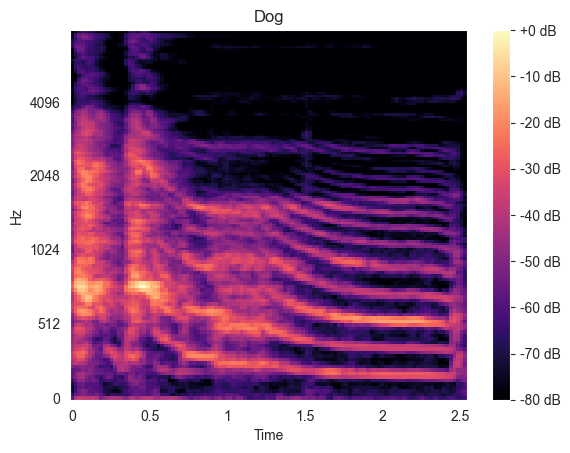

In [6]:
num = 3
processedData = getMelSpecLabel(audiofile=audiofiles[num])
print(audiofiles[num].spec)
plotMel(audiofiles[num])

## Rezising

Als nächstes wird die Information aus dem Data Understanding entnommen und dafür gesorgt, dass alle Spektrogramme die gleiche Länge (7 Sekudnen) haben. Hierfür sind 2 Funktionen implementiert, welche in der Hausarbeit erklärt werden und jeweils Padding und Turncating implementieren.

In [7]:
def pad_resize(audiofile:Sound, width:int):
    if audiofile.spec.shape[1] > width:
      audiofile.spec = audiofile.spec[:, :width]
    else:
        counter = 0
        while audiofile.spec.shape[1] < width:
            new_column = np.array([audiofile.spec[:, counter]]).reshape(128,1)
            audiofile.spec = np.hstack((audiofile.spec, new_column))
            counter += 1

def pad_nulls(audiofile:Sound, width:int):
    if audiofile.spec.shape[1] > width:
        audiofile.spec = audiofile.spec[:, :width]
    else:
        counter = 0
        while audiofile.spec.shape[1] < width:
            audiofile.spec = np.hstack((audiofile.spec, np.zeros(shape=(128,1))))
            counter += 1


## Data Augmentation

Hier werden synthetisch neue Datensätze durch Data Augmentation erstellt. Speziell wird mit einer gewissen Wahrscheinlichkeit operiert, sodass ca. 20% - 30% der fürs Training genutzten Datensätze synthetisch hergestellt werden. Auch ist es um 10% wahrscheinlicher, dass neue Hundedatensätze erstellt werden als für Hunde, damit die ungleiche Verteilung bei der Menge der Trainingsdaten ausgeglichen werden.

In [8]:
def mask_random(audio):
    arr = audio.spec
    mask_rows = np.random.choice([True, False])

    if mask_rows:
        num_rows = arr.shape[0]
        min_rows_to_mask = max(1, int(0.075 * num_rows))
        max_rows_to_mask = min(int(0.20 * num_rows), num_rows)
        num_rows_to_mask = np.random.randint(min_rows_to_mask, max_rows_to_mask + 1)
        start_row = np.random.randint(0, num_rows - num_rows_to_mask + 1)
        arr[start_row:start_row + num_rows_to_mask, :] = 0
    else:
        num_cols = arr.shape[1]
        min_cols_to_mask = max(1, int(0.075 * num_cols))
        max_cols_to_mask = min(int(0.20 * num_cols), num_cols)
        num_cols_to_mask = np.random.randint(min_cols_to_mask, max_cols_to_mask + 1)
        start_col = np.random.randint(0, num_cols - num_cols_to_mask + 1)
        arr[:, start_col:start_col + num_cols_to_mask] = 0

    return Sound(cat=audio.cat, spec=arr, filePath=audio.filePath)

### Beispiel:

Diese Beispiel zeigt wie die mask_radnom-Funktion die Data Augmentation umsetzt.

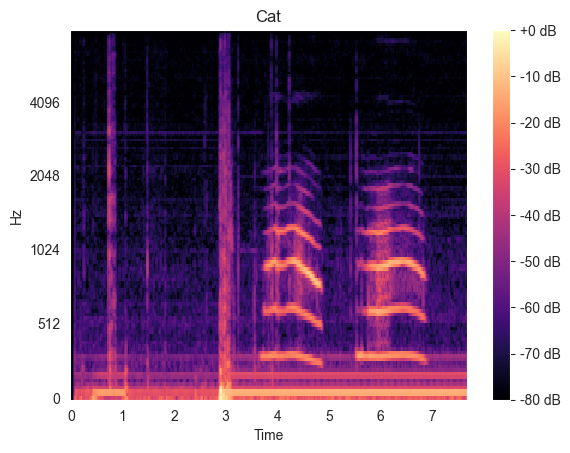

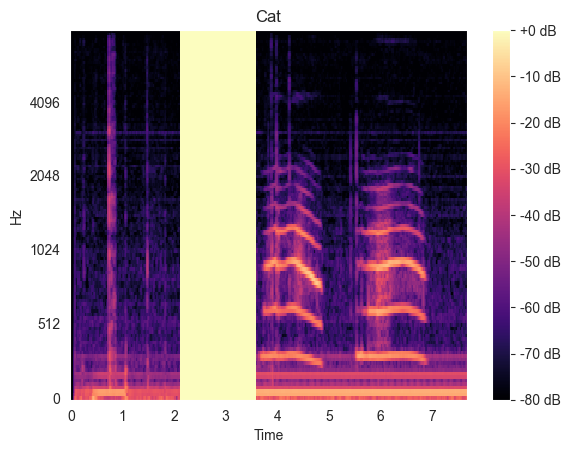

In [9]:
num = 2
getMelSpecLabel(audiofiles[num])
pad_resize(audiofiles[num], 331)
plotMel(audiofiles[num])

# Hier sieht man nur hin und wieder die Maskierung. Wenn die jedes mal gezeigt werden soll, muss die mask_probability = 1 gesetzt werden.
newSound = mask_random(audiofiles[num])
plotMel(newSound)

### Data Preparation

Hier werden alle genannten Data Preparation Methoden genutzt, um die Daten fürs Modell vorzubereiten. Hierzu zählt eine Liste an Labels ("Dog" oder "Cat") und die Liste an Features (Spektrogrammen) Hierbei ist es Wichtig, dass beide Listen in der gleichen Reihenfolge sind, also das feature [x] mit dem label [x] korreliert. Zudem wird die Form (shape) von den Spektrogrammen verändert, sodass diese in der neuen Form ins Trainingsmodell eingefügt werden können.

#### Hinweis:

Labeling und Hinzufügen des Features erfolgen auch bei neuen synthetischen Datensätzen.

In [10]:
features = []
label = []

def init_features(audiofile):
    features.append(audiofile.spec.reshape((128,331,1)))
    if audiofile.cat:
        label.append("Cat")
    else:
        label.append("Dog")

for audiofile in audiofiles:
    getMelSpecLabel(audiofile=audiofile)
    pad_resize(audiofile=audiofile, width=331)
    if audiofile.cat:
        if np.random.rand() < 0.1:
            modified_array  = mask_random(audiofile)
            init_features(modified_array)
    else:
        if np.random.rand() < 0.55:
            modified_array  = mask_random(audiofile)
            init_features(modified_array)

    init_features(audiofile)

features = np.array(features)
labels = np.array(label)

def one_hot(array):
    unique, inverse = np.unique(labels, return_inverse=True)
    onehot = np.eye(unique.shape[0])[inverse]
    return onehot
encoded_labels = one_hot(labels)

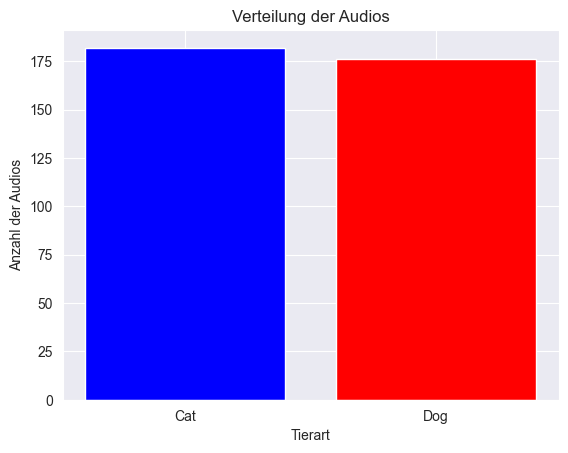

In [11]:
unique_labels, counts = np.unique(labels, return_counts=True)

plt.bar(unique_labels, counts, color = ['blue', 'red'])
plt.title ('Verteilung der Audios')
plt.xlabel ('Tierart')
plt.ylabel('Anzahl der Audios')

plt.show()

In der folgenden Struktur werden die Daten an das Modell überliefert.

In [12]:
features[0].shape

(128, 331, 1)

## The Model

Hier wird das Modell definiert und kompiliert. Weiter unten ist eine Zusammenfassung des Modells sichtbar.

In [13]:
model = keras.Sequential(layers=[
        keras.layers.InputLayer(input_shape=features[0].shape),
        keras.layers.Conv2D(16, 3, padding='same', activation=keras.activations.relu),
        keras.layers.MaxPooling2D(),
        keras.layers.Conv2D(32, 3, padding='same', activation=keras.activations.relu),
        keras.layers.MaxPooling2D(),
        keras.layers.Conv2D(48, 3, padding='same', activation=keras.activations.relu),
        keras.layers.MaxPooling2D(),
        keras.layers.Flatten(),
        keras.layers.Dense(64, activation=keras.activations.relu),
        keras.layers.Dense(2, activation=keras.activations.softmax)
    ])

model.compile(optimizer=keras.optimizers.legacy.Adam(), loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 331, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 165, 16)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 165, 32)       4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 82, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 82, 48)        13872     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 16, 41, 48)        0

### Modell Training

Hier werden die Hyperparameter gesetzt, die Daten in Training und Testdaten geteilt und das Modell trainiert.
Hierbei wird wie in der Ausarbeitung beschrieben, ein early stopping eingesetzt.

In [14]:
TEST_SIZE = 0.2

# 2^x gewählt weil -> macht man halt so
BATCH_SIZE = 48
EPOCHS = 50

X_train, X_test, y_train, y_test = train_test_split(features, encoded_labels, test_size=TEST_SIZE)

# Train the model

# val Daten fürs early stopping
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(x=X_train, y=y_train, validation_split=TEST_SIZE, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[early_stopping])

Epoch 1/50
5/5 [==============================] - 1s 162ms/step - loss: 90.2934 - accuracy: 0.5395 - val_loss: 6.4282 - val_accuracy: 0.4828
Epoch 2/50
5/5 [==============================] - 1s 145ms/step - loss: 3.9821 - accuracy: 0.5175 - val_loss: 1.7468 - val_accuracy: 0.5172
Epoch 3/50
5/5 [==============================] - 1s 150ms/step - loss: 1.3349 - accuracy: 0.5263 - val_loss: 0.6757 - val_accuracy: 0.5000
Epoch 4/50
5/5 [==============================] - 1s 149ms/step - loss: 0.5821 - accuracy: 0.7061 - val_loss: 0.5014 - val_accuracy: 0.7759
Epoch 5/50
5/5 [==============================] - 1s 146ms/step - loss: 0.4745 - accuracy: 0.7895 - val_loss: 0.4549 - val_accuracy: 0.8103
Epoch 6/50
5/5 [==============================] - 1s 147ms/step - loss: 0.3989 - accuracy: 0.8465 - val_loss: 0.3954 - val_accuracy: 0.8966
Epoch 7/50
5/5 [==============================] - 1s 146ms/step - loss: 0.3352 - accuracy: 0.8596 - val_loss: 0.3092 - val_accuracy: 0.8966
Epoch 8/50
5/5 [===

### Ergebnisse

Im folgenden Teil sind die Ergebnisse zu sehen. Bzw. bis zu wie vielen Epochen trainiert wurde und wie die Performance sich über die Zeit verändert hat.

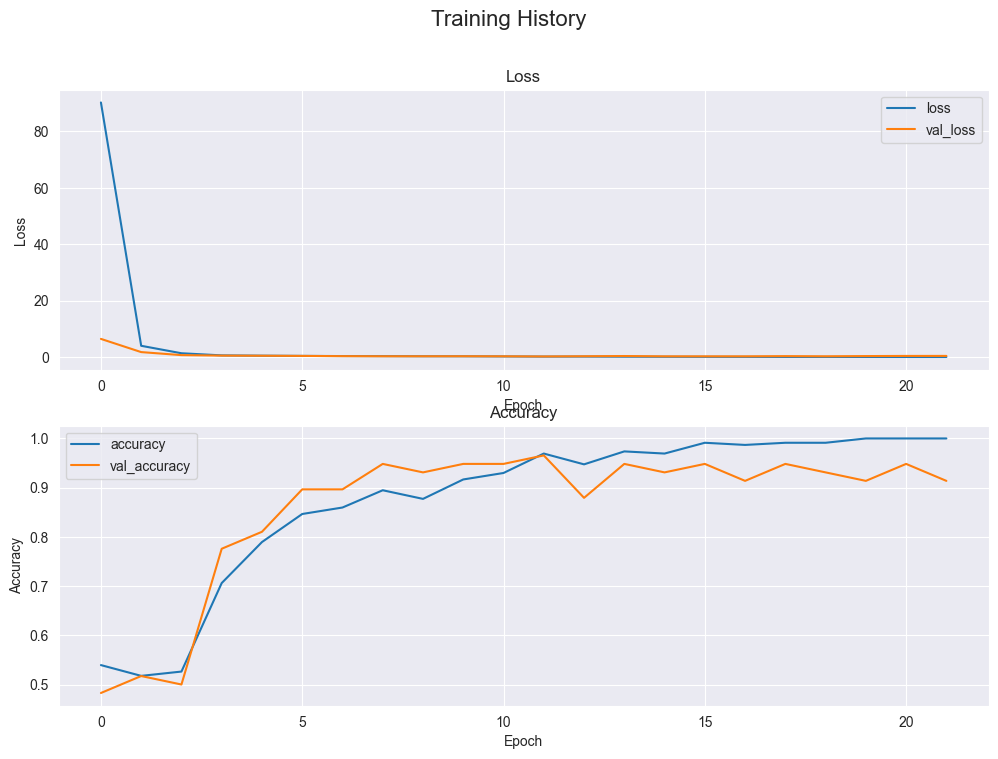

In [15]:
# Plot the training history
fig, axs = plt.subplots(2)
fig.set_size_inches(12, 8)
fig.suptitle('Training History', fontsize=16)
axs[0].plot(history.epoch, history.history['loss'], history.history['val_loss'])
axs[0].set(title='Loss', xlabel='Epoch', ylabel='Loss')
axs[0].legend(['loss', 'val_loss'])
axs[1].plot(history.epoch, history.history['accuracy'], history.history['val_accuracy'])
axs[1].set(title='Accuracy', xlabel='Epoch', ylabel='Accuracy')
axs[1].legend(['accuracy', 'val_accuracy'])
plt.show()

#### weitere Metriken

3/3 [==============================] - 0s 24ms/step


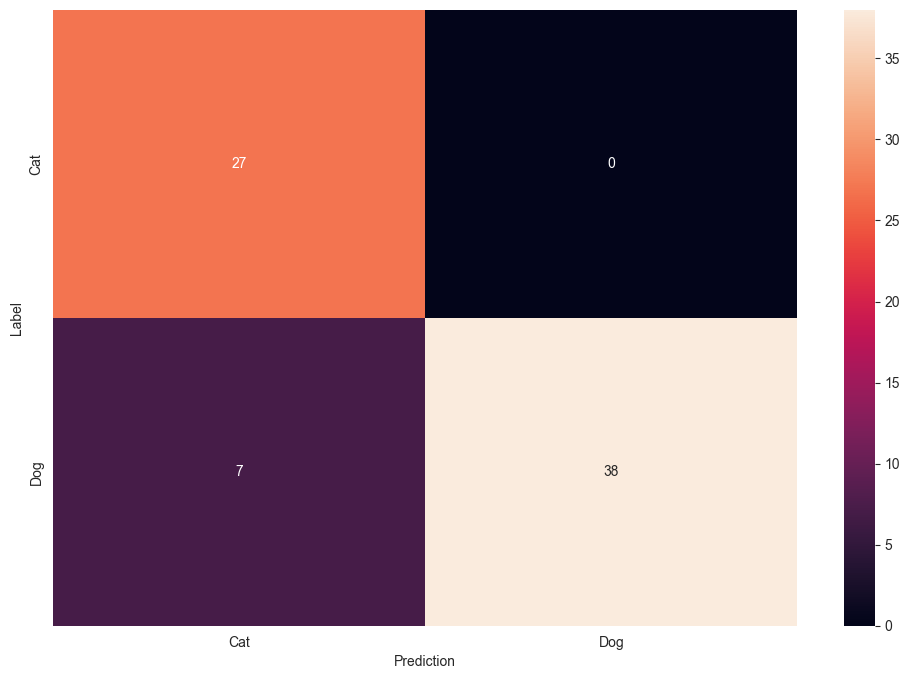

In [16]:
y_predicted = np.argmax(model.predict(x=X_test), axis=1)
y_true = np.argmax(y_test, axis=1)
label_names = np.unique(labels)
confusion_matrix = tf.math.confusion_matrix(labels=y_true, predictions=y_predicted)
fig = plt.figure()
fig.set_size_inches(12, 8)
sns.heatmap(confusion_matrix, xticklabels=label_names, yticklabels=label_names, annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Beispiel

In der folgenden "predict"-Funktion können Objekte vom Typ "Sound" eingesetzt werden, um eine Vorhersage zu generieren.
Sie können z.B: ihr eigenes Haustier aufnehmen und schauen, ob das Modell es erkennt.

In [17]:
def predict(audio:Sound):
    getMelSpecLabel(audio)
    pad_resize(audio, 331)
    audio.spec = audio.spec.reshape((1,128,331,1))
    return model.predict(x=sound1.spec)

In [18]:
sound1 = Sound(DATA_DIR + "cat_3.wav", True)
print(predict(sound1)[0])

1/1 [==============================] - 0s 37ms/step
[0.975582   0.02441797]


## Schluss

Vielen Dank für Ihre Aufmerksamkeit. Bei Fragen zu den Entscheidungen, die zu diesem Notebook/Modell geführt haben, verweisen wir auf die zugehörige Hausarbeit.